In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename)) # printout is to big to display every time
        print('', end='')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# guide followed

https://www.tensorflow.org/tutorials/images/classification

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/

In [4]:
import pathlib
data_dir = pathlib.Path(r"/kaggle/input/vegetable-image-dataset/Vegetable Images/")

image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(image_count)

21000


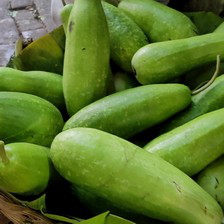

In [5]:
veg = list(data_dir.glob(f'*/Bottle_Gourd/*'))
PIL.Image.open(str(veg[0]))

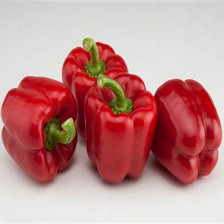

In [6]:
veg = list(data_dir.glob(f'*/Capsicum/*'))
PIL.Image.open(str(veg[0]))

# loading data to Keras utility

In [7]:
batch_size = 32  # can test varrying this value
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path(r"/kaggle/input/vegetable-image-dataset/Vegetable Images/train"),
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15000 files belonging to 15 classes.


2022-12-08 23:43:28.808029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 23:43:28.901788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 23:43:28.902588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 23:43:28.906968: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path(r"/kaggle/input/vegetable-image-dataset/Vegetable Images/validation"),
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 15 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


# visualize the data

2022-12-08 23:43:31.782731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


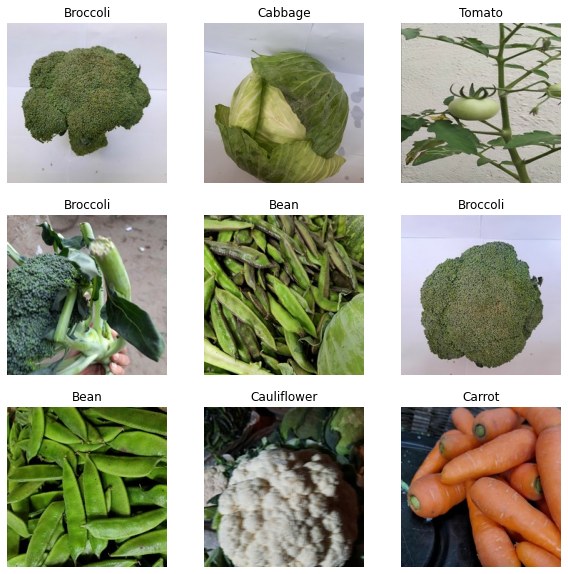

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2022-12-08 23:43:43.969601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 133 of 1000
2022-12-08 23:43:53.948856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 274 of 1000
2022-12-08 23:44:04.007901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 389 of 1000


0.015686275 0.9921569


2022-12-08 23:44:11.120525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


# A basic Keras model

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2022-12-08 23:44:12.657741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


469/469 [==============================] - 25s 39ms/step - loss: 1.1308 - accuracy: 0.6393 - val_loss: 0.5197 - val_accuracy: 0.8373
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 0.3307 - accuracy: 0.9006 - val_loss: 0.3332 - val_accuracy: 0.9020
Epoch 3/10
469/469 [==============================] - 9s 20ms/step - loss: 0.1547 - accuracy: 0.9539 - val_loss: 0.2718 - val_accuracy: 0.9200
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0911 - accuracy: 0.9729 - val_loss: 0.2317 - val_accuracy: 0.9350
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0685 - accuracy: 0.9802 - val_loss: 0.5893 - val_accuracy: 0.8690
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0640 - accuracy: 0.9807 - val_loss: 0.3070 - val_accuracy: 0.9297
Epoch 7/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 0.2836 - val_accuracy: 0.9353
Epoch 8/1

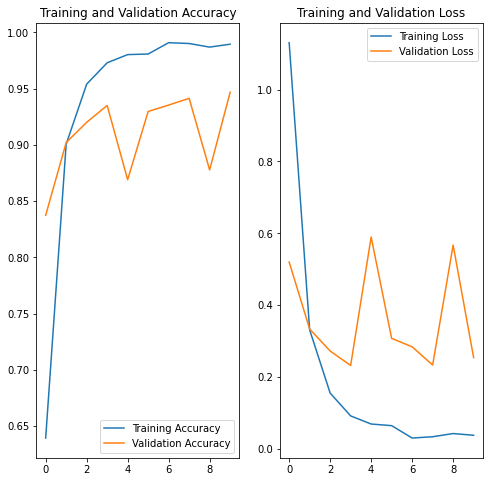

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict New Data

This image most likely belongs to Tomato with a 99.98 percent confidence.
tf.Tensor(
[4.24949139e-05 9.44975625e-07 7.00370046e-13 1.27928986e-04
 2.87251059e-05 1.19456045e-05 2.63667076e-14 8.40072335e-24
 1.77535253e-06 4.15096451e-13 1.24544998e-16 1.66453180e-08
 2.59656949e-11 9.16221648e-14 9.99786198e-01], shape=(15,), dtype=float32)


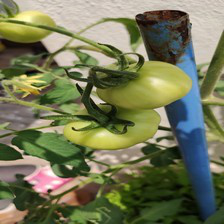

In [22]:
import random

veg = random.choice(list(data_dir.glob('test/*/*.jpg')))

img = tf.keras.utils.load_img(
    veg, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score)

PIL.Image.open(veg)

This image most likely belongs to Capsicum with a 100.00 percent confidence.


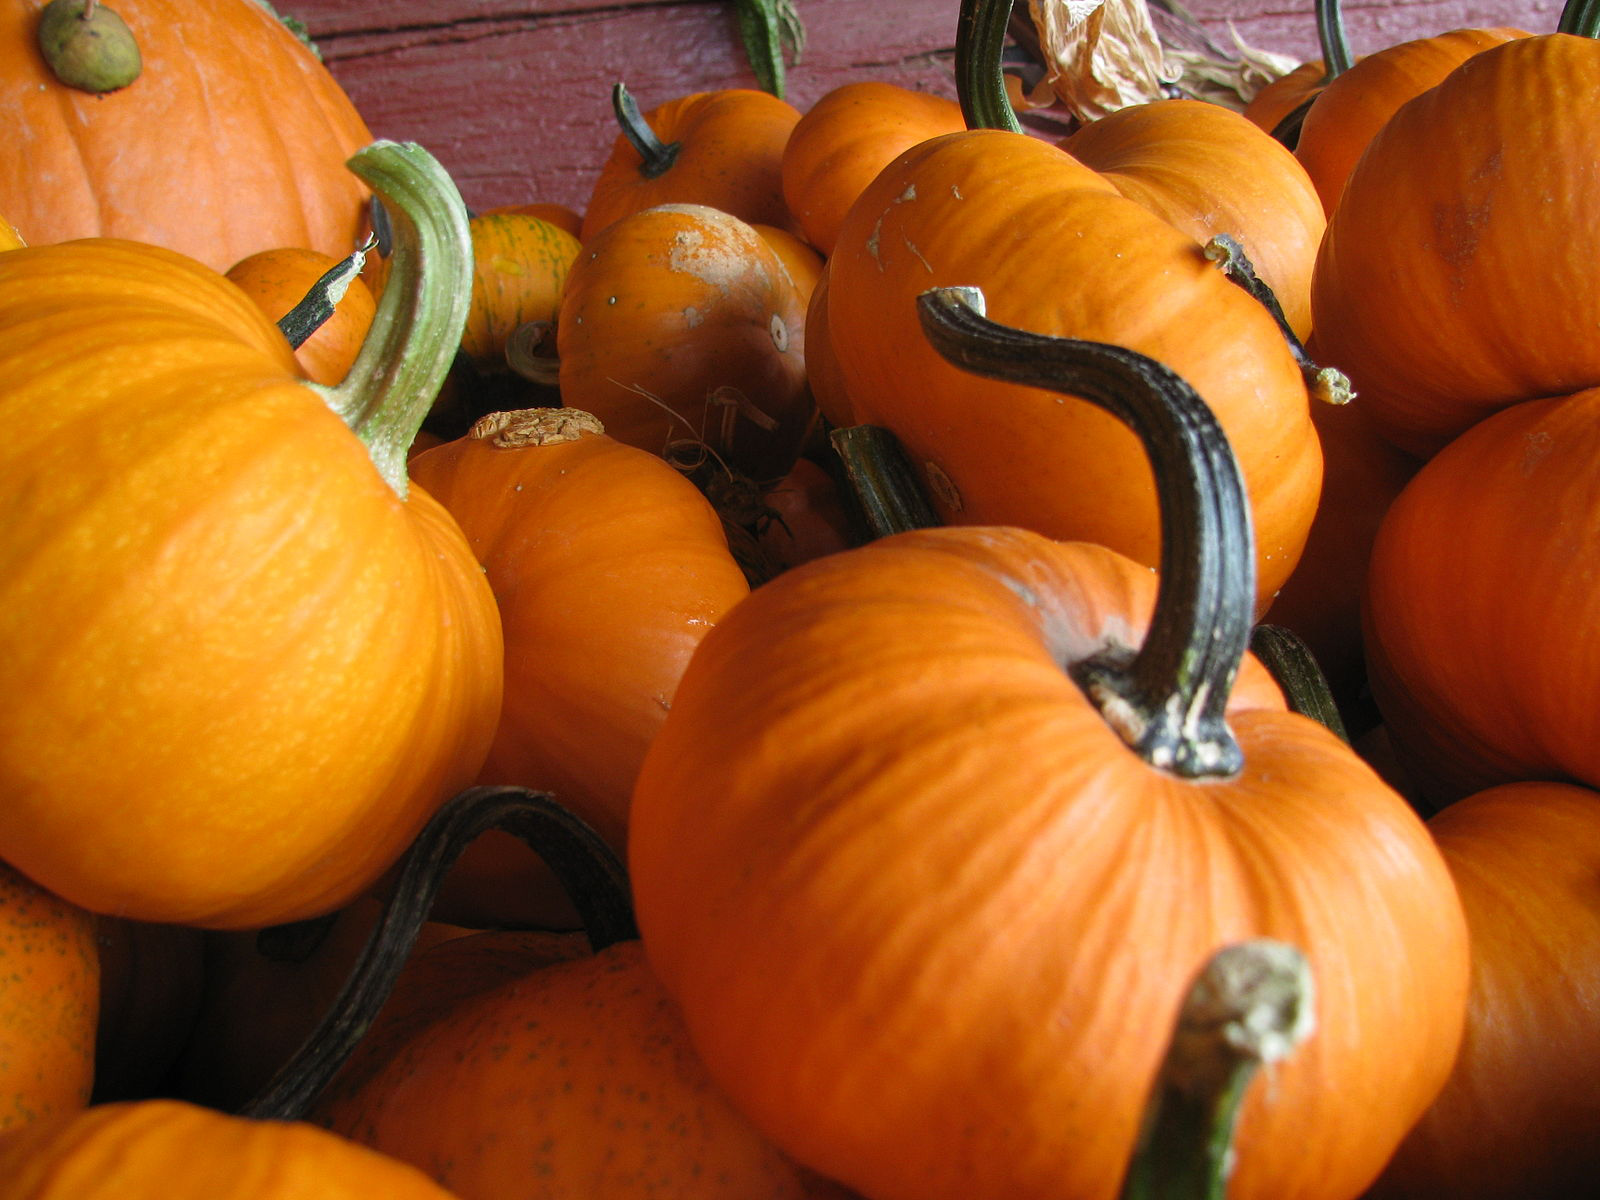

In [23]:
test_img_path = r'/kaggle/input/veg-images-personal-images/Pumpkins_1.jpeg'

PIL.Image.open(test_img_path)

img = tf.keras.utils.load_img(
    test_img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

PIL.Image.open(test_img_path)